# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import csv
import io
import json
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import torch
from PIL import Image
from rich import print
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

###### Function definitions


In [2]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def get_num_findings(string):
    if string == "No Finding":
        return 1
    else:
        return string.count(")")


def is_label_in_response(series):
    if series["finding_labels"] in series["response"]:
        return True
    else:
        return False


def is_true_positive(series):
    if series["label_in_response"] and (series["response_num_findings"] == 1):
        return True
    else:
        return False

## NIH Chest X-ray dataset


###### Load dataset


In [3]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Rows: 112,120   Columns: 11

Number of patients: 30,805

###### Visualize data


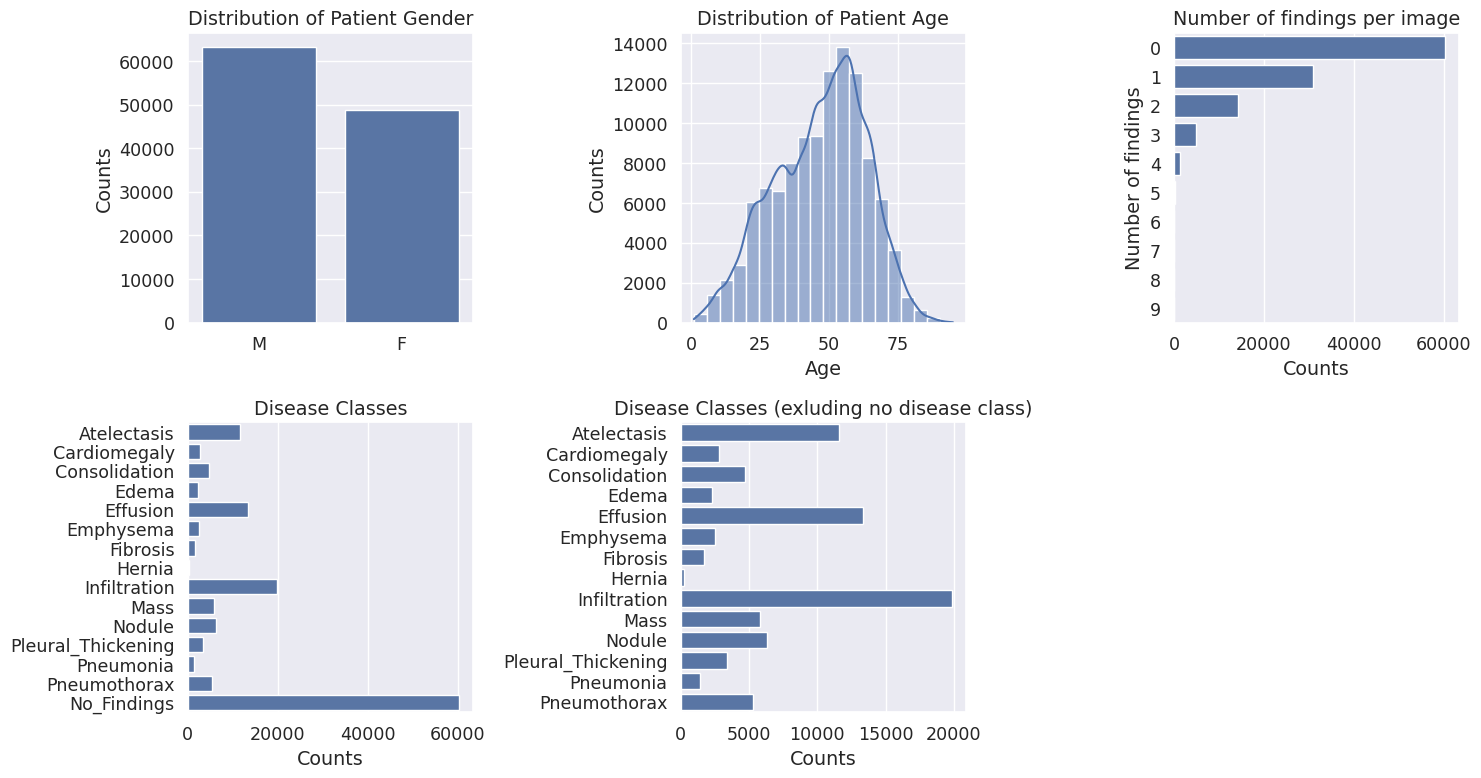

In [4]:
GOLDEN = (1 + 5**0.5) / 2
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [5]:
data = data[column_names]

## Using CheXagent


###### CheXagent: Load Processor and Model


In [ ]:
device = "cuda"
dtype = torch.float16

processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True).to(
    device
)

###### Apply CheXagent on single image


In [ ]:
# subset: cases with exactly one finding label, first case of each label
subset = data.loc[data.iloc[:, 11:].apply(sum, axis=1) == 1, :].sample(1)
image_dir = "./data/NIH_Chest_X-ray_Dataset"
image_path = next(Path(image_dir).rglob(subset["image_index"].values[0])).as_posix()
image = Image.open(image_path).convert("RGB")

img_name, label = subset["image_index"].values[0], subset["finding_labels"].values[0]
plot_title = f"Label: {label} ({img_name})"
plot_img(image, plot_title)

prompt = """
From the following list of findings, identify which finding is present in the this chest X-ray:
'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'.
If no findings are present, respond by stating 'No Finding'.
"""

warnings.filterwarnings("ignore", category=UserWarning)
response = generate([image], prompt, processor, model, device, dtype, generation_config)
warnings.resetwarnings()

print(f"Correct finding: {subset['finding_labels'].values[0]}")
print(f"CheXagent response: {response}")

### Prompt engineering for disease classification


###### Define prompts


In [ ]:
# # fmt: off
# prompts = {}
# prompts["1"] = """From the following list of findings, identify which finding is present in the this chest X-ray:
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'.
# If no findings are present, respond by stating 'No Finding'."""
# prompts["2"] = """Which finding is in this chest X-ray: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["3"] = """Which single finding is in this chest X-ray: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["4"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'. Do not select muliple findings."""
# prompts["5"] = """This chest X-ray has exacltly one disease condition. Identify the correct disease condition from the following options: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["6"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', O) 'No Finding'. What is the correct disease condition?"""
# prompts["7"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list:
#     A) 'Atelectasis'
#     B) 'Cardiomegaly'
#     C) 'Consolidation'
#     D) 'Edema'
#     E) 'Effusion'
#     F) 'Emphysema'
#     G) 'Fibrosis'
#     H) 'Hernia'
#     I) 'Infiltration'
#     J) 'Mass'
#     K) 'Nodule'
#     L) 'Pleural_Thickening'
#     M) 'Pneumonia'
#     N) 'Pneumothorax'
#     O) 'No Finding'
# What is the correct disease condition?"""
# prompts["8"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list:
#     A) Atelectasis
#     B) Cardiomegaly
#     C) Consolidation
#     D) Edema
#     E) Effusion
#     F) Emphysema
#     G) Fibrosis
#     H) Hernia
#     I) Infiltration
#     J) Mass
#     K) Nodule
#     L) Pleural_Thickening
#     M) Pneumonia
#     N) Pneumothorax
#     O) No Finding
# What is the correct disease condition?"""
# prompts["9"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list:
#     A) 'Atelectasis'
#     B) 'Cardiomegaly'
#     C) 'Consolidation'
#     D) 'Edema'
#     E) 'Effusion'
#     F) 'Emphysema'
#     G) 'Fibrosis'
#     H) 'Hernia'
#     I) 'Infiltration'
#     J) 'Mass'
#     K) 'Nodule'
#     L) 'Pleural_Thickening'
#     M) 'Pneumonia'
#     N) 'Pneumothorax'
#     O) 'No Finding'
# Do not select muliple findings."""
# prompts["10"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list:
#     A) Atelectasis
#     B) Cardiomegaly
#     C) Consolidation
#     D) Edema
#     E) Effusion
#     F) Emphysema
#     G) Fibrosis
#     H) Hernia
#     I) Infiltration
#     J) Mass
#     K) Nodule
#     L) Pleural_Thickening
#     M) Pneumonia
#     N) Pneumothorax
#     O) No Finding
# Do not select muliple findings."""
# # fmt: on

In [ ]:
# import prompts dictionary
with open("output/prompts.json", "r") as json_file:
    prompts = json.load(json_file)

# export prompts dictionary
# with open("output/prompts.json", "w") as json_file:
# json.dump(prompts, json_file, indent=4)

#### Prepare input data for CheXagent


###### Load previous Q and A results


In [ ]:
results_prev = pd.read_csv("output/disease_classification_QA.csv",
                           usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
display(results_prev.head())
print(f"nRows: {results_prev.shape[0]:,}\tnColumns: {results_prev.shape[1]}")

###### Get images in NIH dataset that have not been supplied to CheXagent


In [ ]:
# images with missing prompt cases
images_incomplete = (
    results_prev.groupby(["image_index"], as_index=True, sort=False)["prompt_key"]
    .apply(lambda x: x.nunique())
    .pipe(lambda x: x[x != len(prompts)])
    .index.to_list()
)

# images that have been analyed
images_analyzed = set(results_prev["image_index"].values) - set(images_incomplete)

# images to input into CheXagent
images_not_analyzed = set(data["image_index"].values) - images_analyzed
subset = data[data["image_index"].isin(images_not_analyzed)].copy()
display(subset.head())
print(f"nRows: {subset.shape[0]:,}\tnColumns: {subset.shape[1]}")

#### Apply CheXagent on NIH dataset using `prompts`


In [ ]:
now = datetime.now()
datetime_str = now.strftime("%Y%m%d_%H%M%S")
csv_file_path = f"output/disease_classification_QA_{datetime_str}.csv"

warnings.filterwarnings("ignore", category=UserWarning)

with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["image_index", "finding_labels", "prompt", "prompt_key", "response"])

    for _, row in tqdm(subset.iterrows(), total=subset.shape[0], desc="Processing images"):
        images = [Image.open(row["image_path"]).convert("RGB")]
        img_name, label = row["image_index"], row["finding_labels"]
        title = f"Label: {label} ({img_name})"
        for prompt_key, prompt in prompts.items():
            response = generate(images, prompt, processor, model, device, dtype, generation_config)
            row_data = [img_name, label, prompt, prompt_key, response]
            writer.writerow(row_data)

warnings.resetwarnings()

# ran for 1422m 24.9s
# tqdm bar: 5%    4891/91324    [23:42:22<582:23:29, 24.26s/it]

## Analyze prompts and responses


###### import results


In [6]:
results = pd.read_csv(
    "output/disease_classification_QA.csv",
    usecols=["image_index", "finding_labels", "prompt_key", "response"],
    dtype=str,
)

# make "prompt_key" categorical
results["prompt_key"] = pd.Categorical(results["prompt_key"], ordered=True, categories=[str(x) for x in range(1, 11)])

###### analyze response strings


In [7]:
results["response_num_findings"] = results["response"].transform(get_num_findings)
results["label_in_response"] = results.apply(is_label_in_response, axis=1)
results["true_positive"] = results.apply(is_true_positive, axis=1)

display(results.head())
print(f"nRows: {results.shape[0]:,}\tnCols: {results.shape[1]}")

,image_index,finding_labels,prompt_key,response,response_num_findings,label_in_response,true_positive
0,00000001_000.png,Cardiomegaly,9,B) 'Cardiomegaly',1,True,True
1,00000001_000.png,Cardiomegaly,10,B) Cardiomegaly,1,True,True
2,00000001_000.png,Cardiomegaly,4,B) 'Cardiomegaly',1,True,True
3,00000001_000.png,Cardiomegaly,1,No Finding,1,False,False
4,00000001_000.png,Cardiomegaly,5,"A) 'Atelectasis', B) 'Cardiomegaly', D) 'Edema...",4,True,False


nRows: 48,936   nCols: 7

#### Plots


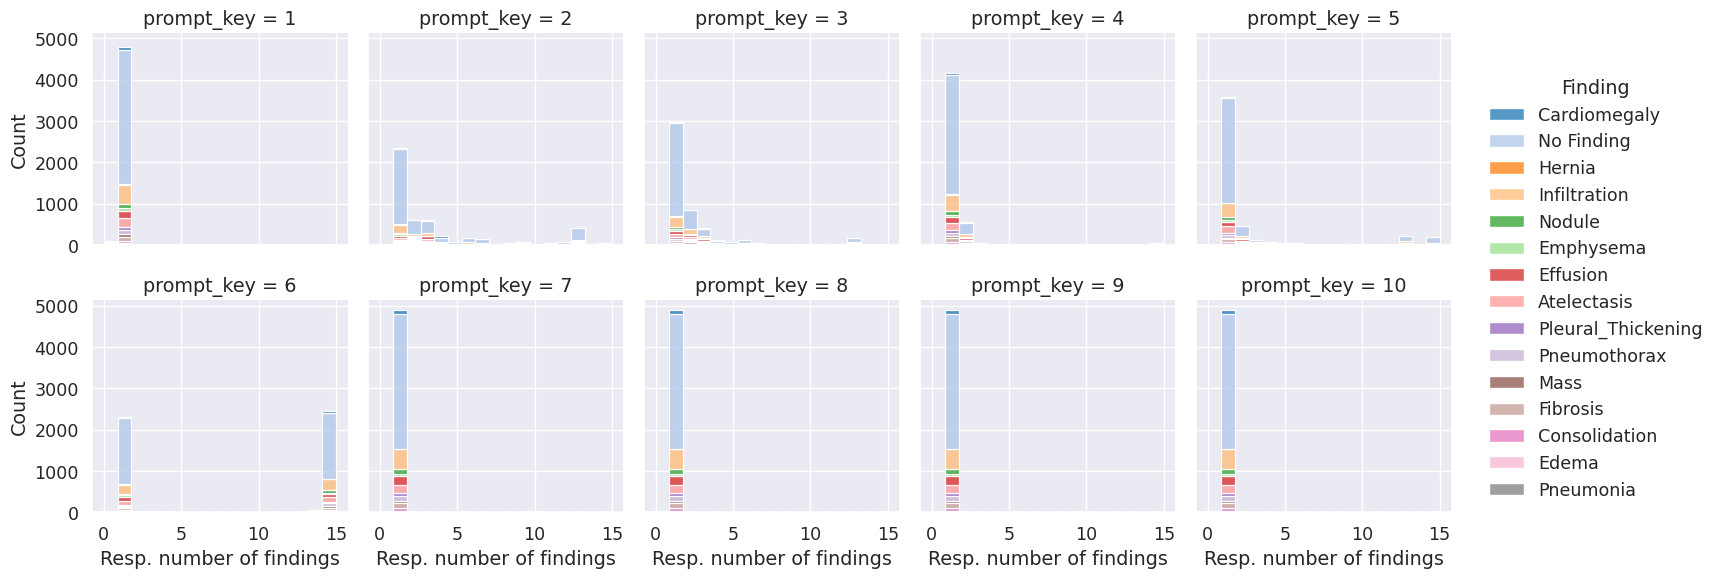

In [8]:
plotdf = results
plotdf["response_num_findings_grouped"] = plotdf["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)

g = sns.displot(
    data=plotdf,
    # data=plotdf[plotdf["finding_labels"] != "No Finding"],
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3,
    hue="finding_labels",
    multiple="stack",
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

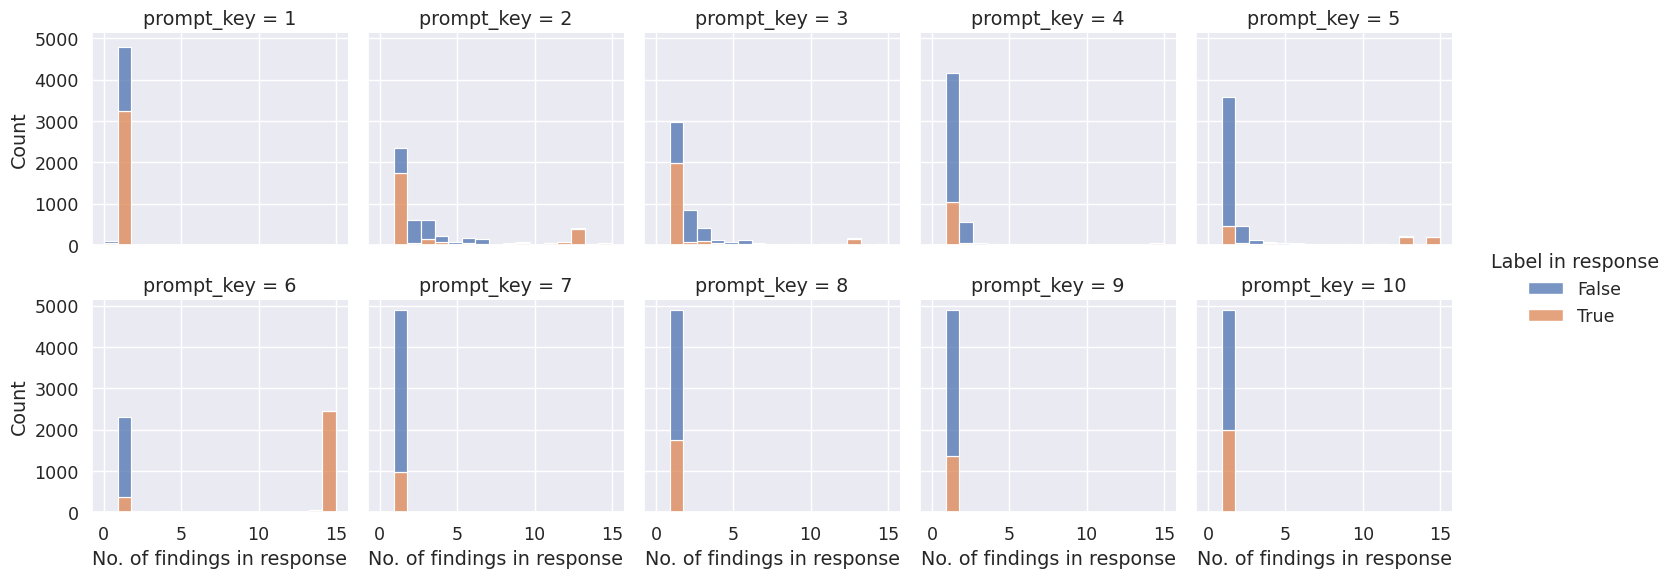

In [9]:
plotdf = results
plotdf["response_num_findings_grouped"] = plotdf["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)

g = sns.displot(
    data=plotdf,
    # data=plotdf[plotdf["finding_labels"] != "No Finding"],
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    col="prompt_key",
    col_wrap=5,
    height=3,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

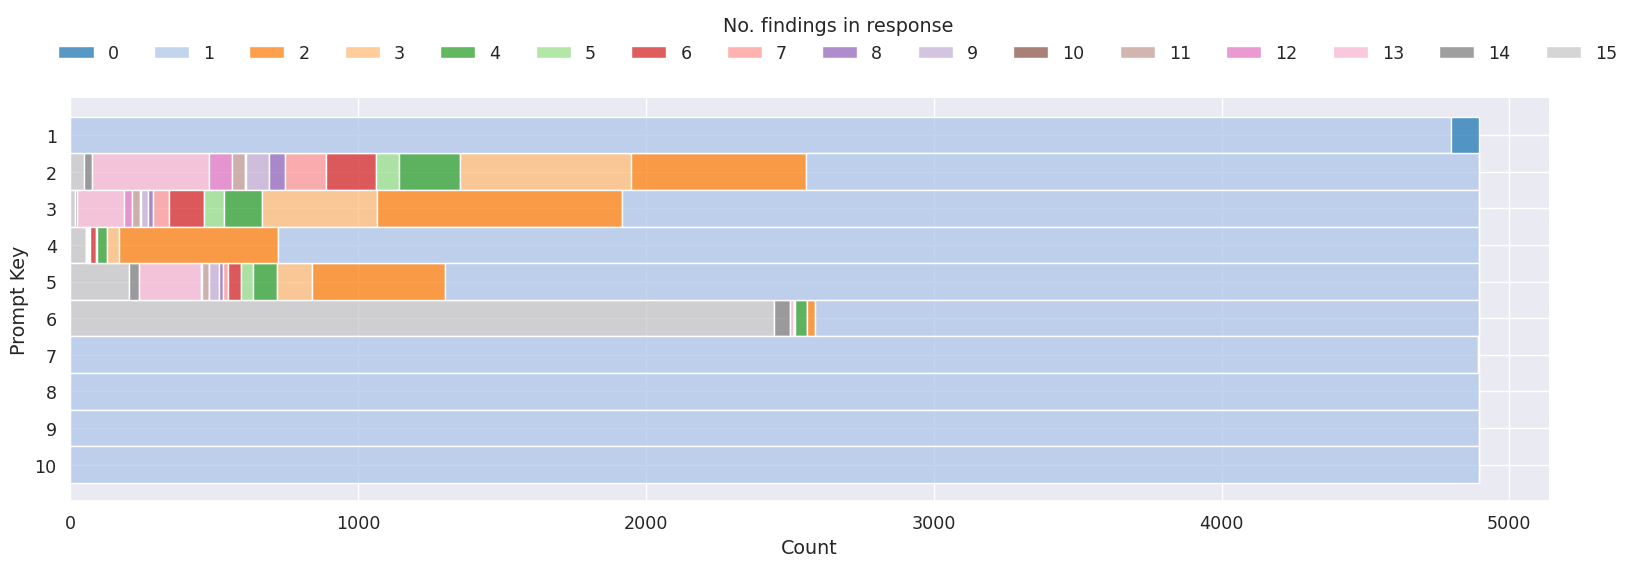

In [10]:
plotdf = results
plotdf["response_num_findings_grouped"] = plotdf["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)

g = sns.displot(
    data=plotdf,
    # data=plotdf[plotdf["finding_labels"] != "No Finding"],
    y="prompt_key",
    hue="response_num_findings_grouped",
    multiple="stack",
    palette="tab20",
    aspect=3.2,
)

g.set_axis_labels(x_var="Count", y_var="Prompt Key")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.44, 1), ncol=16, title="No. findings in response")
g.tight_layout()
plt.show()

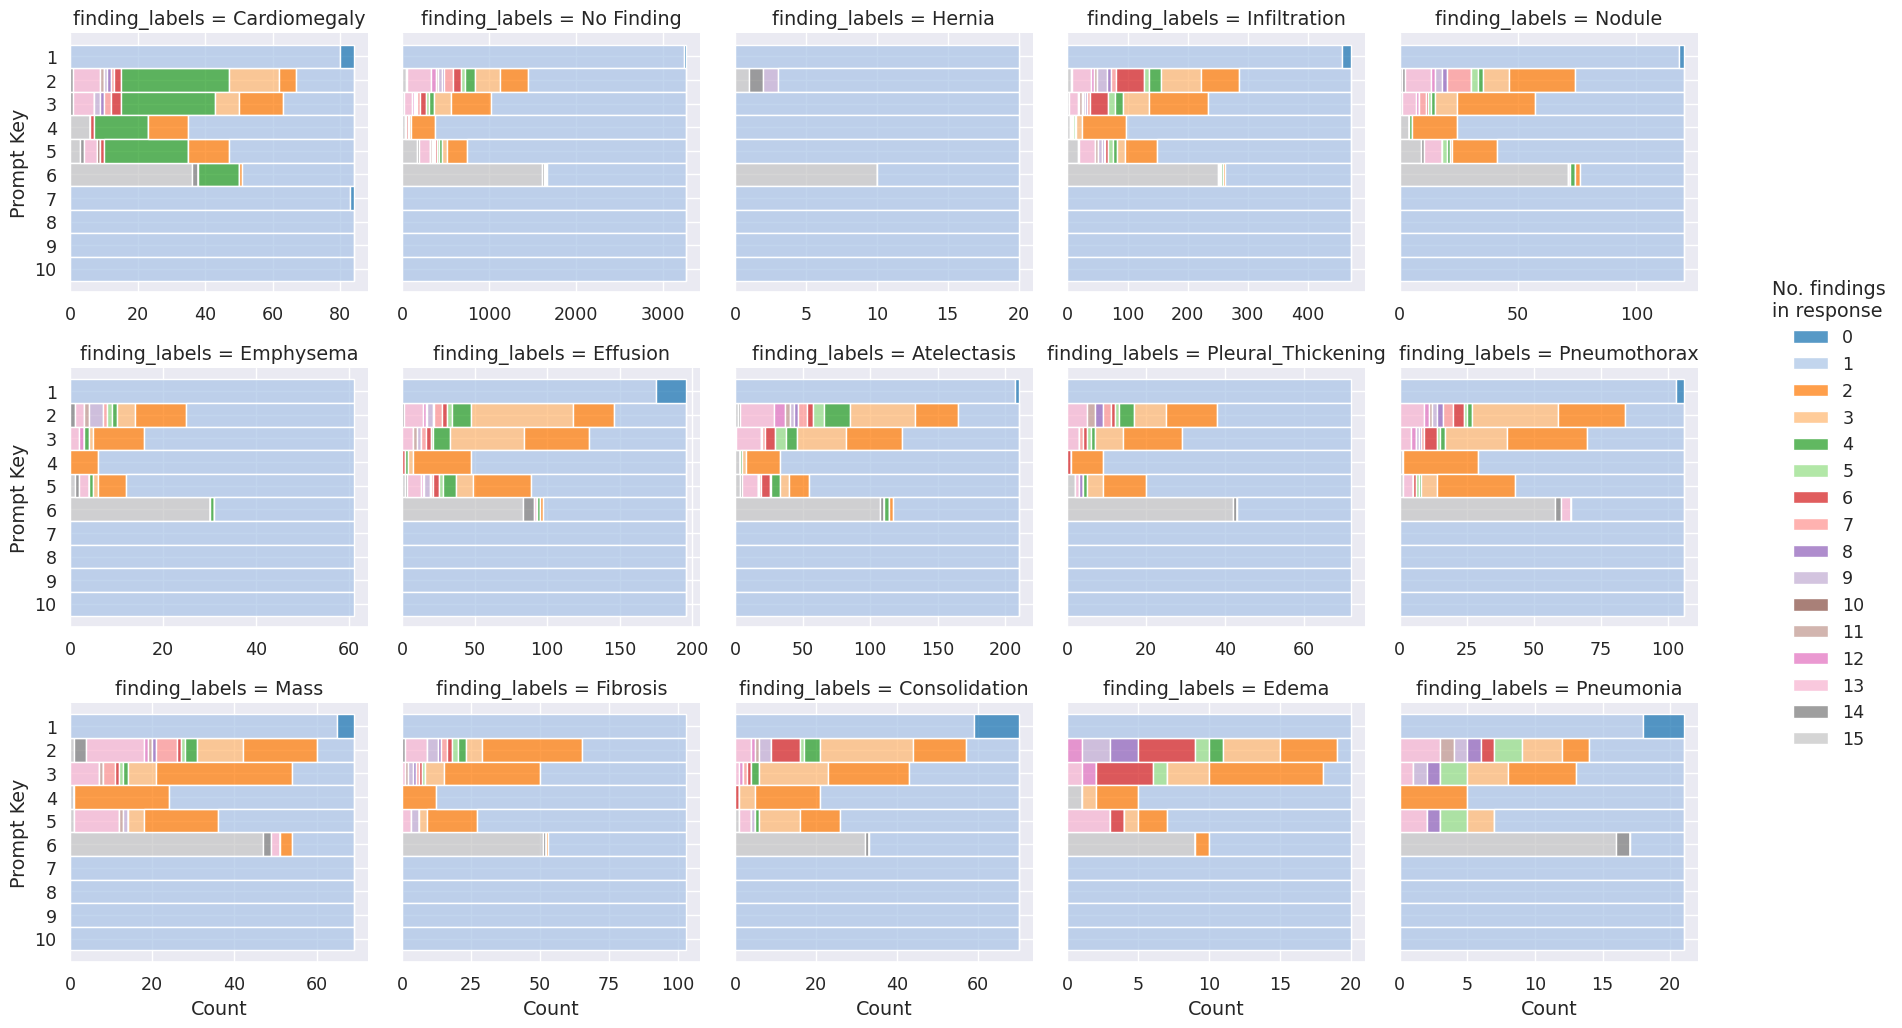

In [11]:
plotdf = results
plotdf["response_num_findings_grouped"] = plotdf["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)

g = sns.displot(
    data=plotdf,
    # data=plotdf[plotdf["finding_labels"] != "No Finding"],
    y="prompt_key",
    hue="response_num_findings_grouped",
    multiple="stack",
    palette="tab20",
    col="finding_labels",
    col_wrap=5,
    facet_kws={"sharex": False},
    height=3.5,
)

g.set_axis_labels(x_var="Count", y_var="Prompt Key")
sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5), title="No. findings\nin response")
g.tight_layout()
plt.show()

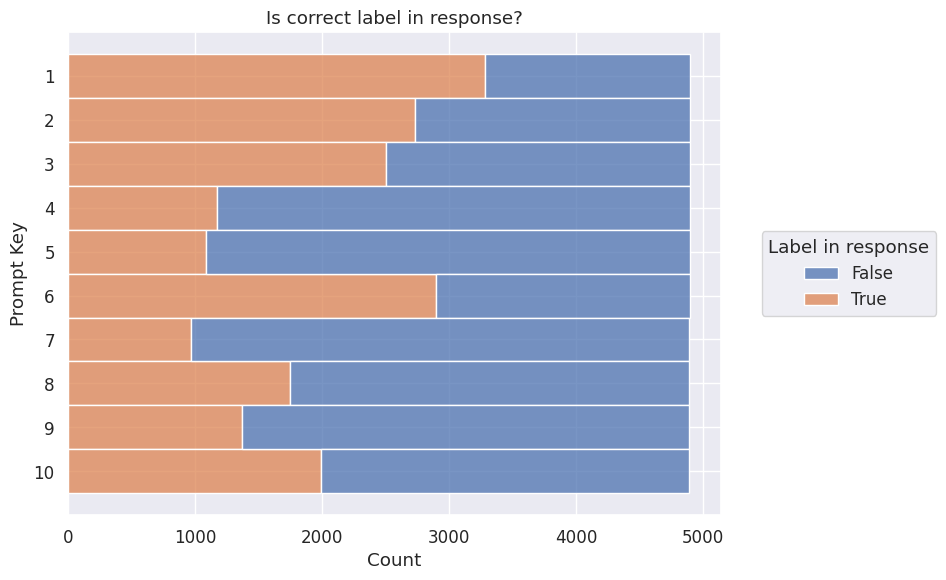

In [12]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

plt.figure(figsize=(GOLDEN * 6, 6))
sns.histplot(
    data=results,
    y="prompt_key",
    hue="label_in_response",
    multiple="stack",
)
sns.move_legend(plt.gca(), "center left", bbox_to_anchor=(1.05, 0.5), title="Label in response")
plt.gca().set(title="Is correct label in response?", ylabel="Prompt Key")
plt.tight_layout()
plt.show()

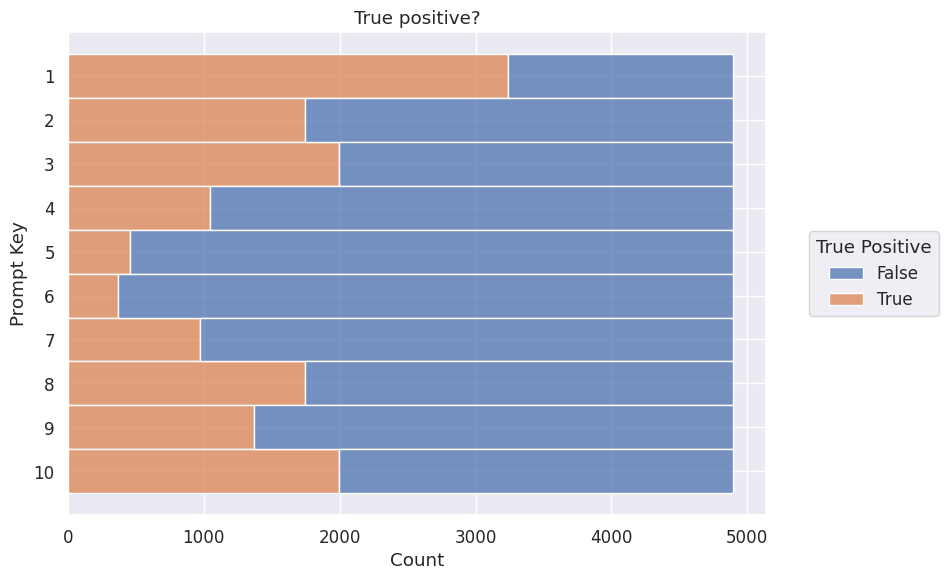

In [13]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

plt.figure(figsize=(GOLDEN * 6, 6))
sns.histplot(
    data=results,
    y="prompt_key",
    hue="true_positive",
    multiple="stack",
)
sns.move_legend(plt.gca(), "center left", bbox_to_anchor=(1.05, 0.5), title="True Positive")
plt.gca().set(title="True positive?", ylabel="Prompt Key")
plt.tight_layout()
plt.show()

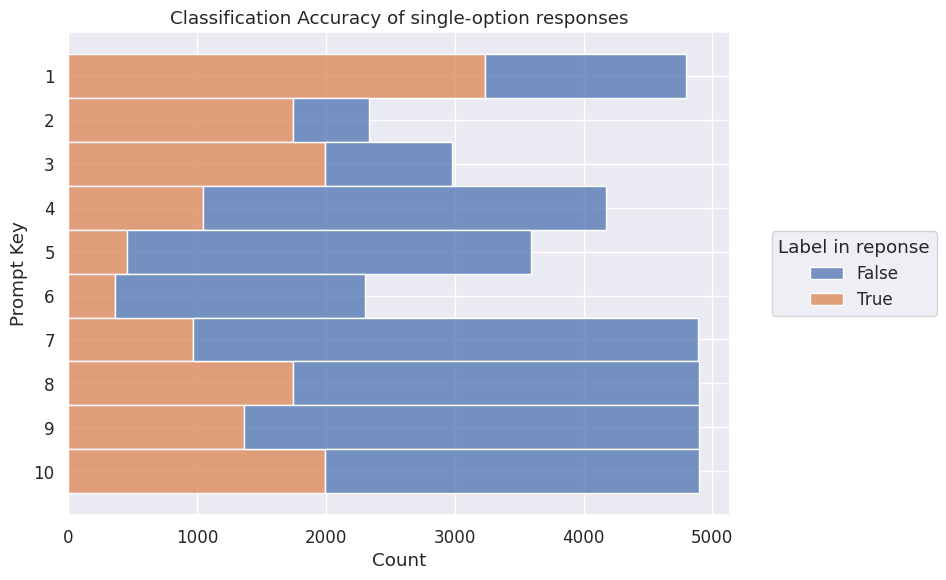

In [14]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

plt.figure(figsize=(GOLDEN * 6, 6))
sns.histplot(
    data=results[results["response_num_findings"] == 1],
    y="prompt_key",
    hue="label_in_response",
    multiple="stack",
)
sns.move_legend(plt.gca(), "center left", bbox_to_anchor=(1.05, 0.5), title="Label in reponse")
plt.gca().set(title="Classification Accuracy of single-option responses", ylabel="Prompt Key")
plt.tight_layout()
plt.show()

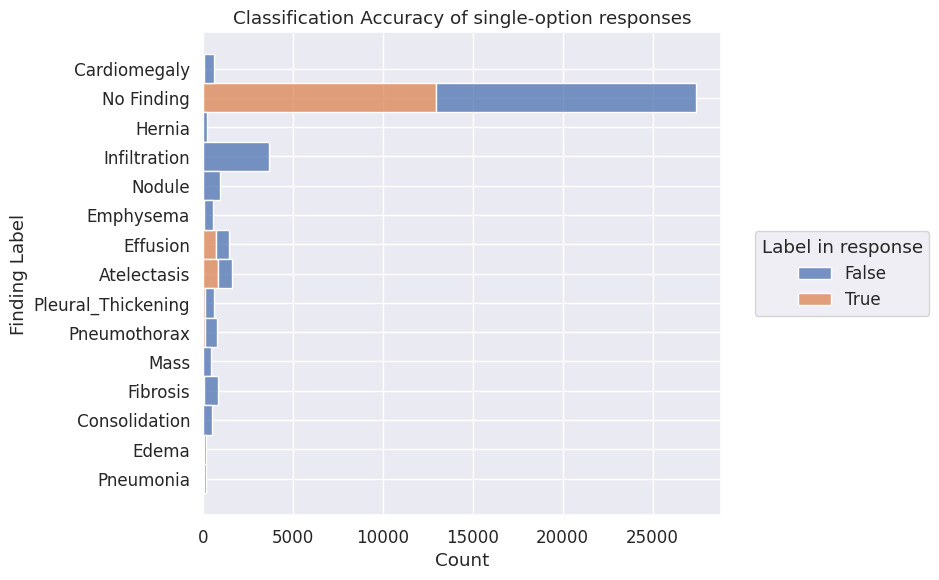

In [15]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

plt.figure(figsize=(GOLDEN * 6, 6))
sns.histplot(
    # data=results,
    data=results[results["response_num_findings"] == 1],
    y="finding_labels",
    hue="label_in_response",
    multiple="stack",
)
sns.move_legend(plt.gca(), "center left", bbox_to_anchor=(1.05, 0.5), title="Label in response")
plt.gca().set(title="Classification Accuracy of single-option responses", ylabel="Finding Label")
plt.tight_layout()
plt.show()

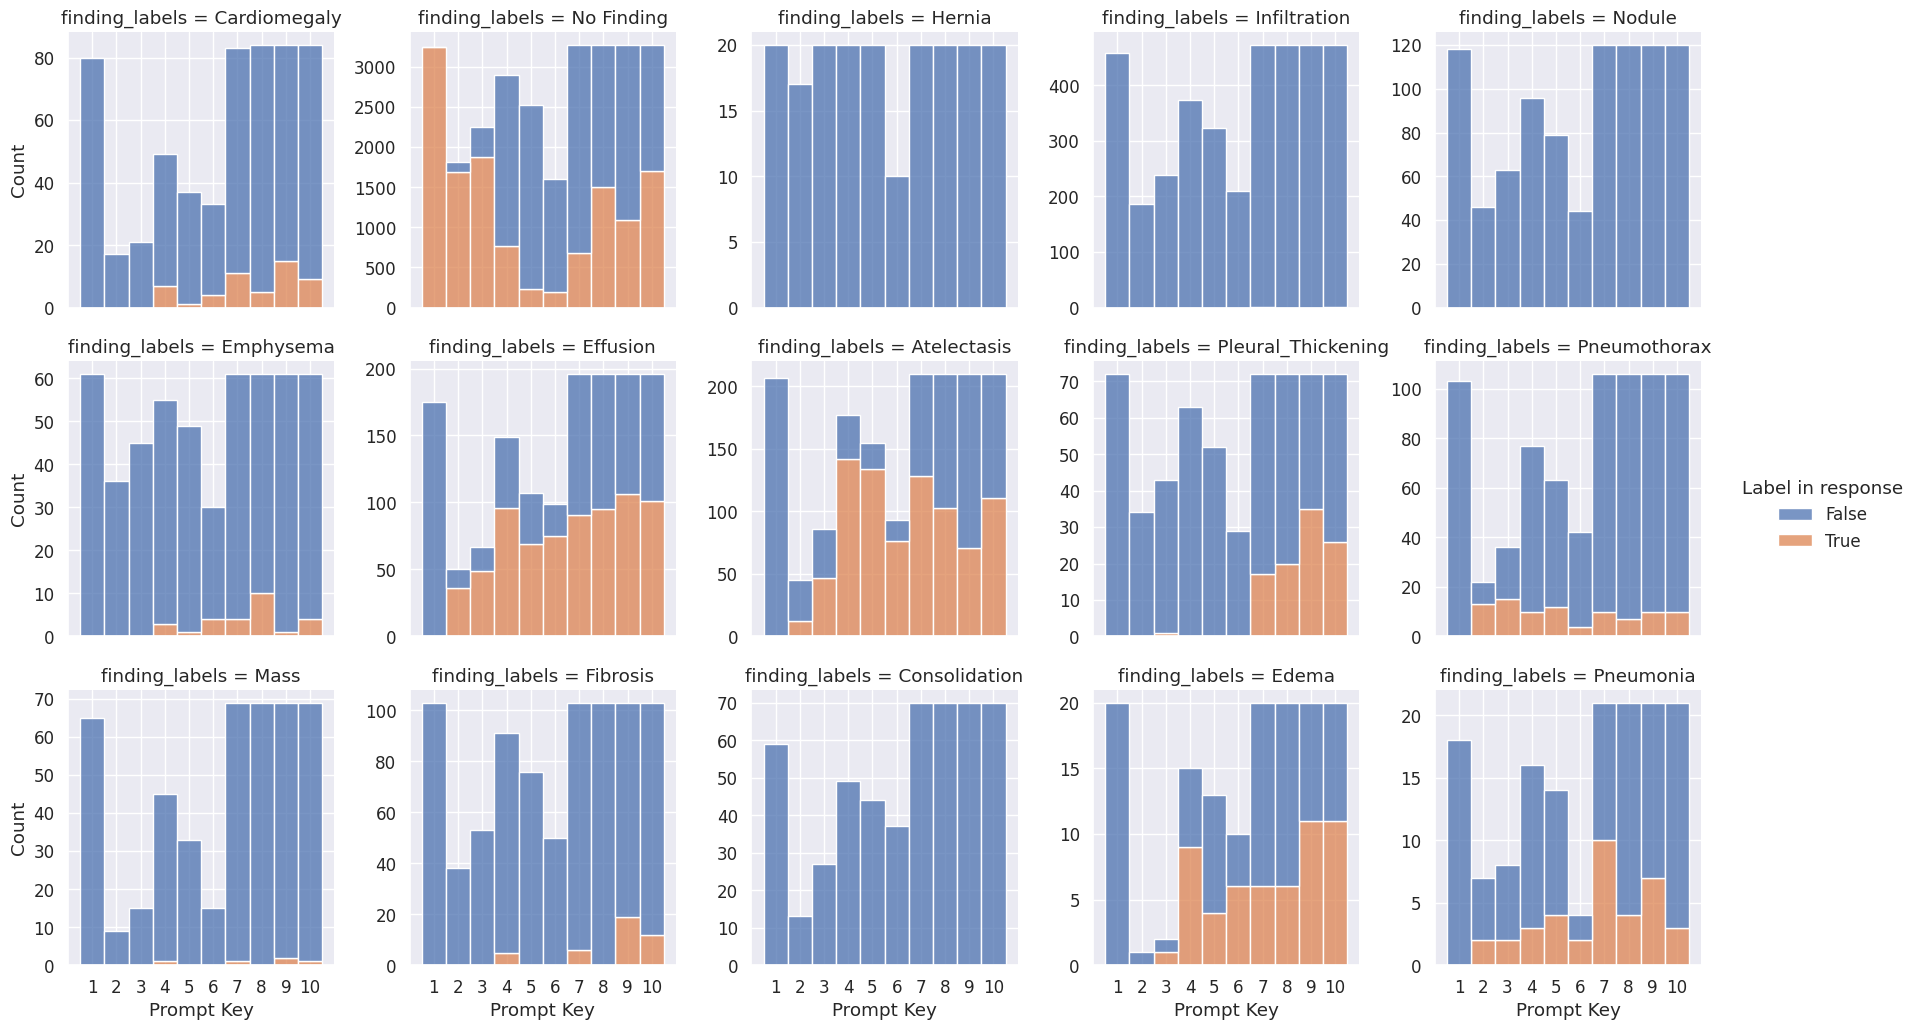

In [16]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

g = sns.displot(
    data=results[results["response_num_findings"] == 1],
    x="prompt_key",
    hue="label_in_response",
    col="finding_labels",
    col_wrap=5,
    multiple="stack",
    height=3.5,
    facet_kws={"sharey": False},
)
g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

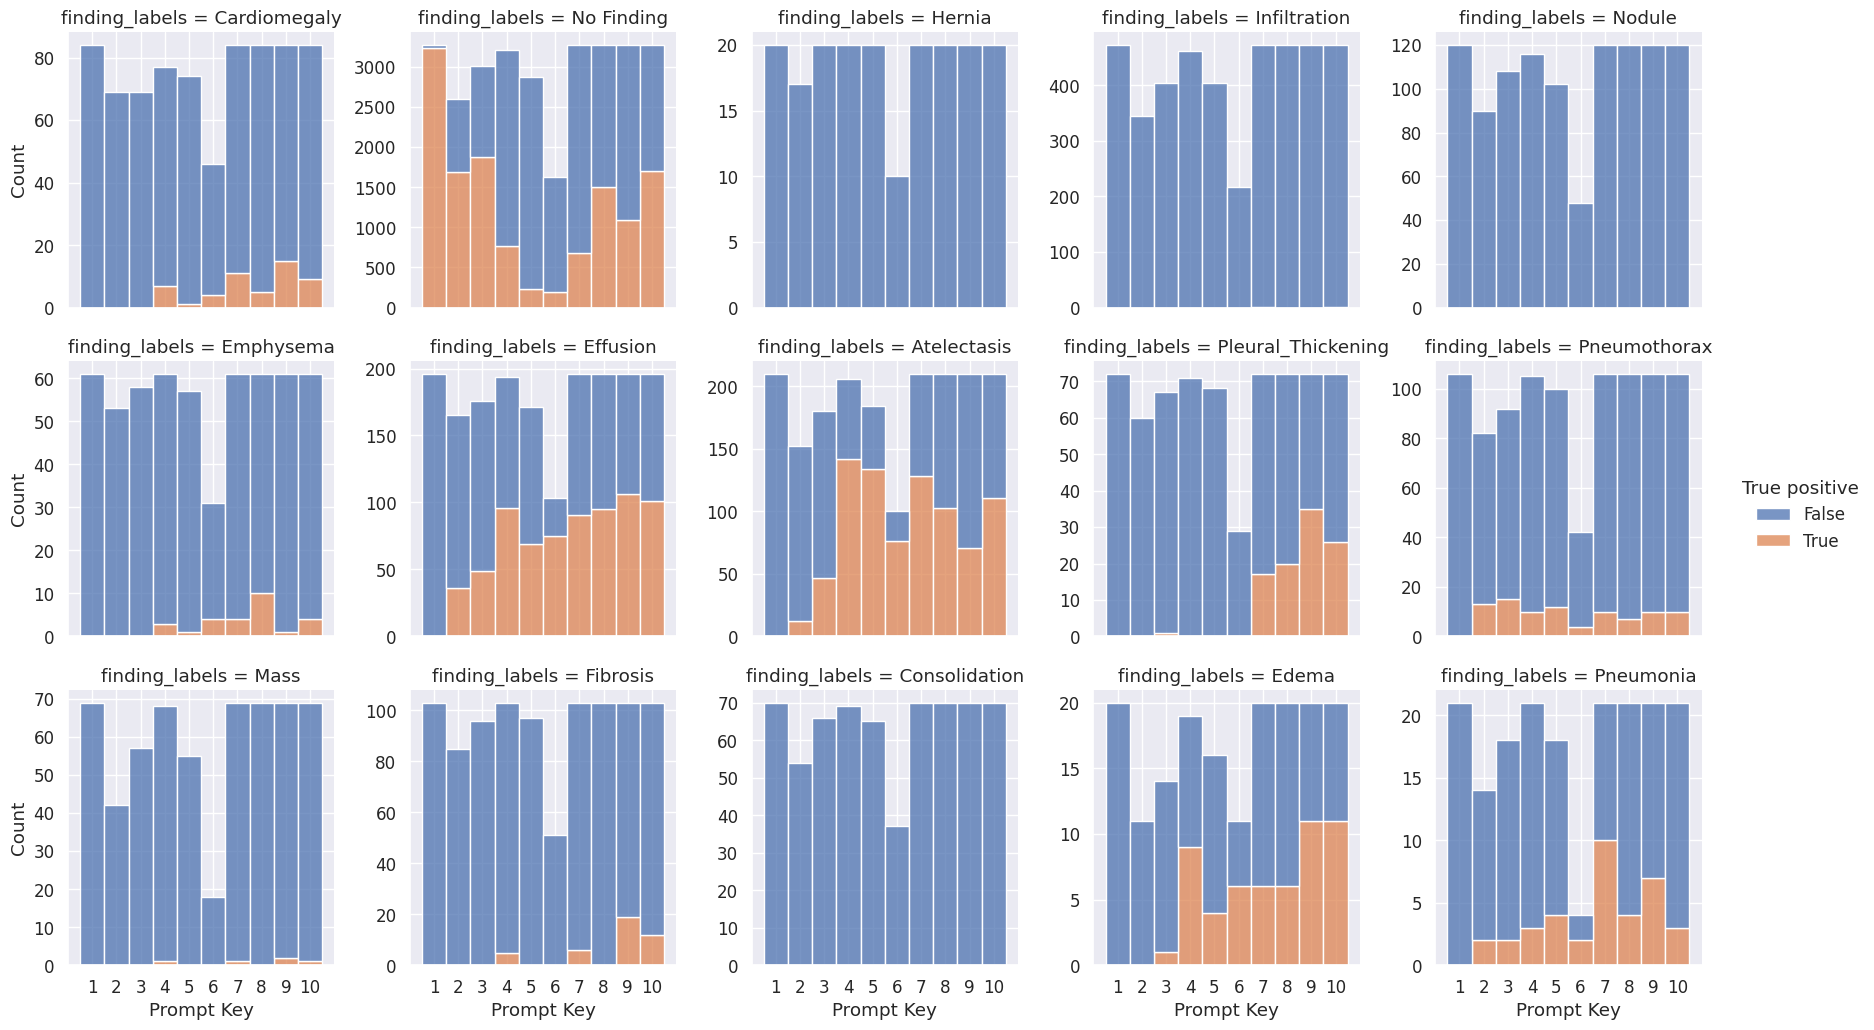

In [17]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.10)

g = sns.displot(
    data=results[results["response_num_findings"] <= 5],
    # data=results[results["response_num_findings"] == 1],
    x="prompt_key",
    hue="true_positive",
    col="finding_labels",
    col_wrap=5,
    multiple="stack",
    height=3.5,
    facet_kws={"sharey": False},
)
g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "right", title="True positive")
g.tight_layout()
plt.show()

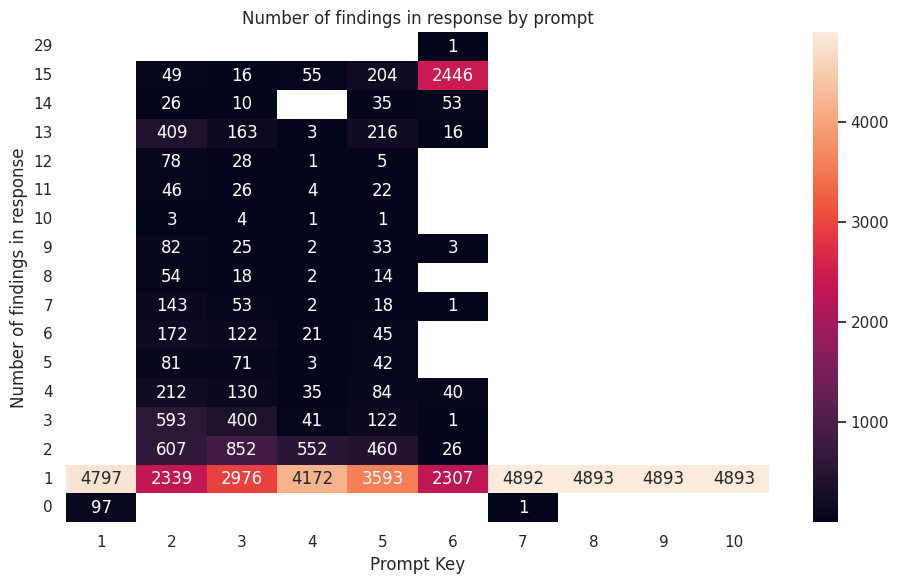

In [18]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(title="Number of findings in response by prompt", xlabel="Prompt Key", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

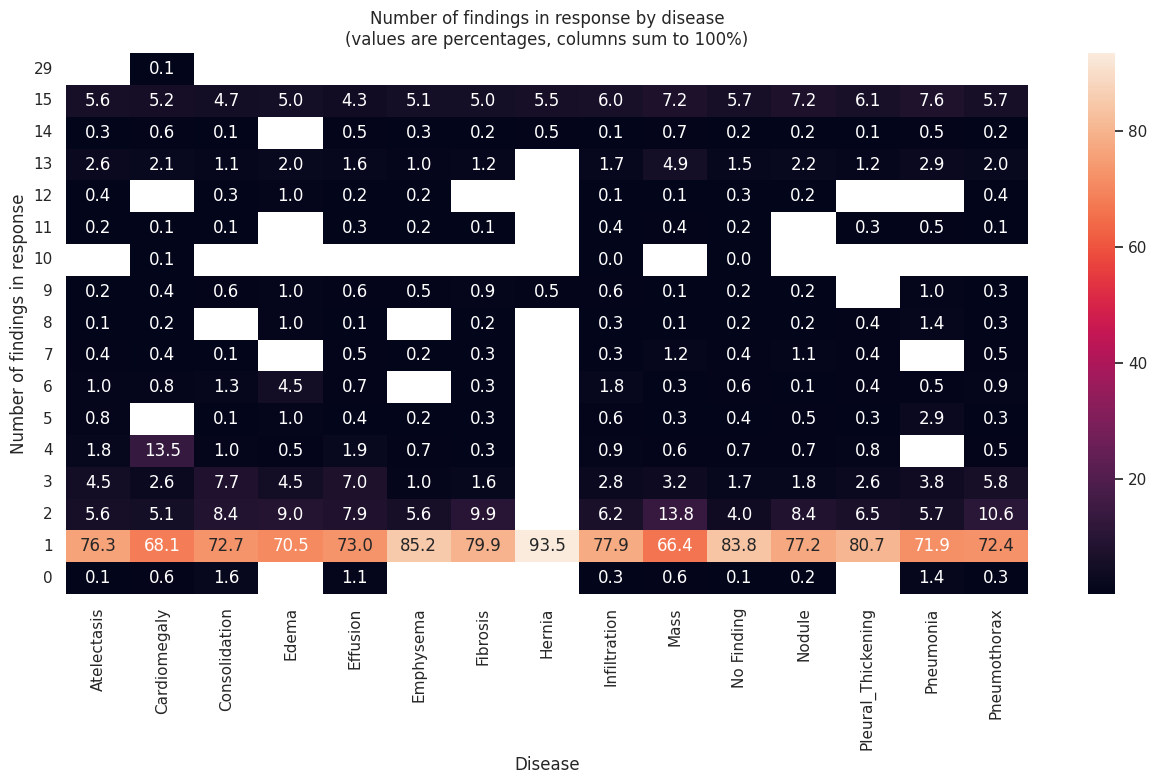

In [19]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)", xlabel="Disease", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()